Representative figures that will be used for poster / papers

In [1186]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

import sys
sys.path.append("../include")
import hhtools
import hhsignal

sys.path.append("../three_pop_mpi/clustering")
import hhclustering as hc
import utils

sys.path.append("../gen_three_pop_samples/multifreq_burst/")
import burst_tools as bt

import pandas as pd

import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [714]:
# common functions
def rm_spines(targets=("right", "top", "bottom", "left")):
    for pos in targets:
        plt.gca().spines[pos].set_visible(False)
        
    
import matplotlib
import matplotlib.offsetbox
from matplotlib.lines import Line2D

import os

def load_figdat(fname):
    fname = os.path.join("./data", fname)
    if os.path.exists(fname):
        with open(fname, "rb") as fp:
            return pkl.load(fp)["figdata"]
    else:
        return None
    

def save_figdat(fname, data):
    with open(os.path.join("./data", fname), "wb") as fp:
        pkl.dump({"figdata": data}, fp)

def splice_t(y, ts, trange):
    idt = (ts >= trange[0]) & (ts < trange[1])
    return y[idt], ts[idt]

def add_scalebar(barsize, label, loc="lower left", ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    ob = AnchoredHScaleBar(ax=ax, size=barsize, label=label, loc=loc, frameon=False,
                           pad=0.08, sep=2, **kwargs)
    ax.add_artist(ob)

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linecolor="k",
                 fontcolor="k", fontsize=10, fontstyle="normal", **kwargs):
        if not ax:
            ax = plt.gca()
            
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], color=linecolor)
        vline1 = Line2D([0,0], [-extent/2.,extent/2.], color=linecolor)
        vline2 = Line2D([size,size], [-extent/2.,extent/2.], color=linecolor)
        vline3 = Line2D([size/2,size/2], [-extent/4.,extent/4.], color=linecolor)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        size_bar.add_artist(vline3)
        txt = matplotlib.offsetbox.TextArea(label, textprops=dict(color=fontcolor, size=fontsize, style=fontstyle))
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)

# Two population parameter selection
: iso-firing rate line

## Parameter space 

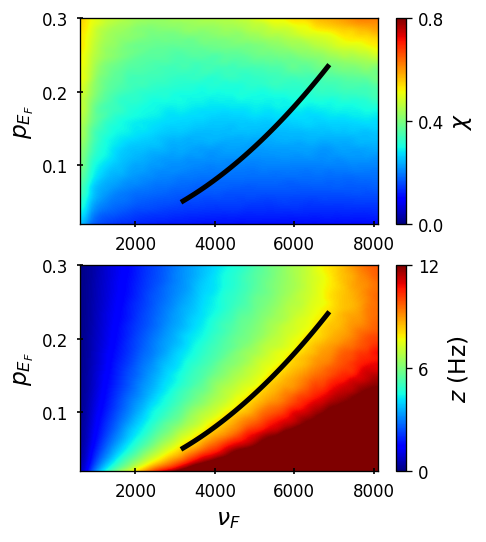

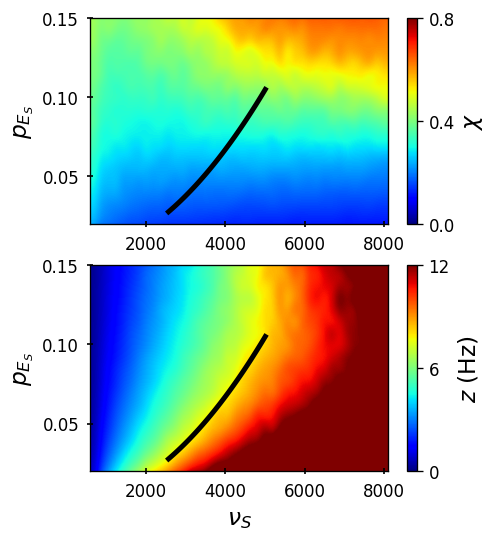

In [1331]:
fname = "two_pop_params.pkl"
data = load_figdat(fname)
if data is None:
    obj_grid = hhtools.SummaryLoader("../two_pop_mpi/data/async/")
    x = obj_grid.controls["nu_ext"]
    y = obj_grid.controls["p_exc"]
    summary = [{k: np.average(obj_grid.summary[k][:,:,ntype,:,0], axis=2) for k in ("chi", "frs_m", "cv")} for ntype in range(2)]
    save_figdat(fname, {"x": x, "y": y, "summary": summary})
    
else:
    x = data["x"]
    y = data["y"]
    summary = data["summary"]


# load grid


tp_labels = ("F", "S")
var_labels = dict(chi=r"$\chi$", frs_m=r"$z$ (Hz)")


# title_name = [r"$\chi$", "firing rate (Hz)"]

popt = [5*1e-9, 4.189*1e-9]
xrange = [[3202.97, 6841.41],
          [2571.79, 5005.13]]

vmaxs = dict(chi=0.8, frs_m=12)
ylims = [[0.02, 0.3],
          [0.02, 0.15]]
yticks = [[0.1, 0.2, 0.3],
          [0.05, 0.1, 0.15]]

for ntype in range(2):
    x_fit = np.linspace(xrange[ntype][0], xrange[ntype][1], 50)
    y_fit = popt[ntype] * x_fit**2
    
    plt.figure(dpi=120, figsize=(4, 5)); nn = 0
    for var in ("chi", "frs_m"):
        plt.subplot(2,1,nn+1)

        # plt.figure(dpi=120, figsize=(4, 2.5))
        hhtools.imshow_xy(summary[ntype][var], x=x, y=y, cmap="jet",
                          vmin=0, vmax=vmaxs[var], interpolation="bicubic")
        plt.plot(x_fit, y_fit, '-', c='k', lw=3, zorder=1)
        cbar = plt.colorbar(ticks=[0,vmaxs[var]/2,vmaxs[var]])
        cbar.set_label(var_labels[var], fontsize=14)

        plt.gca().tick_params(axis="x", direction="inout", width=1, pad=5)
        plt.gca().tick_params(axis="y", direction="inout", width=1, pad=5)
        # plt.ylim([0.02, 0.3])
        # plt.yticks([0.1, 0.2, 0.3])
        plt.xticks([2000, 4000, 6000, 8000])
        plt.ylim(ylims[ntype])
        plt.yticks(yticks[ntype])
        
        plt.ylabel(r"$p_{E_%s}$"%(tp_labels[ntype]), fontsize=14)
        nn += 1
    
    # plt.tight_layout()
    plt.xlabel(r"$\nu_{%s}$"%(tp_labels[ntype]), fontsize=14)
    plt.show()
        
# plt.tight_layout()

# plt.show()

## Properties 

In [318]:
# load line
obj_line = hhtools.SummaryLoader("../two_pop_mpi/data/line")
obj_line.summary["net_freq"] = np.zeros_like(obj_line.summary["chi"])
sz = obj_line.summary["net_freq"].shape

for n1 in range(sz[0]):
    for n2 in range(sz[1]):
        for n3 in range(sz[2]):
            for n4 in range(sz[3]):
                data = obj_line.load_detail(n1, n2, n3)
                obj_line.summary["net_freq"][n1, n2, n3, n4] = hhsignal.get_frequency_peak(data["vlfp"][0])

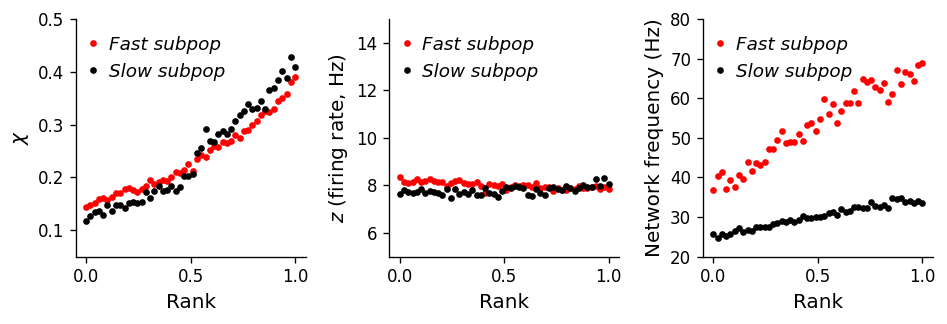

In [1329]:
from scipy.signal import savgol_filter
import matplotlib.font_manager as font_manager

fname = "two_pop_result.pkl"
data = load_figdat(fname)
if data is None:
    obj_line = hhtools.SummaryLoader("../two_pop_mpi/data/line")
    obj_line.summary["net_freq"] = np.zeros_like(obj_line.summary["chi"])
    sz = obj_line.summary["net_freq"].shape

    for n1 in range(sz[0]):
        for n2 in range(sz[1]):
            for n3 in range(sz[2]):
                for n4 in range(sz[3]):
                    data = obj_line.load_detail(n1, n2, n3)
                    obj_line.summary["net_freq"][n1, n2, n3, n4] = hhsignal.get_frequency_peak(data["vlfp"][0])
    
    summary = [{var: np.average(np.average(obj_line.summary[var][:,nt,:,:], axis=1), axis=1) for var in ("chi", "frs_m", "cv", "net_freq")}
               for nt in range(2)]
    save_figdat(fname, summary)
                    
else:
    summary = data["summary"]


pop_lbs = ("Fast subpop", "Slow subpop")
ylb = [r"$\chi$", r"$z$ (firing rate, Hz)", "Network frequency (Hz)"]
yls = [[0.05, 0.5],
       [5, 15],
       [20, 80]]
yticks = [[0.1, 0.2, 0.3, 0.4, 0.5],
          [6, 8, 10, 12, 14],
          np.arange(20, 81, 10)]

fig, axs = plt.subplots(1, 3, dpi=120, figsize=(8, 2.8))
rank = np.linspace(0, 1, len(obj_line.controls["rank"]))
cs = ["r", "k"]


font = font_manager.FontProperties(style='italic', size=11)

for n, var in enumerate(["chi", "frs_m", "net_freq"]):
    plt.axes(axs[n])
    for nt in range(2):
        # y = np.average(np.average(obj_line.summary[var][:,nt,:,:], axis=1), axis=1)
        y = summary[nt][var]
        plt.plot(rank, y, '.', c=cs[nt], label=pop_lbs[nt])
    plt.xlabel("Rank", fontsize=12, style="normal")
    plt.ylabel(ylb[n], fontsize=12, style="normal")
    plt.ylim(yls[n])
    plt.xticks([0, 0.5, 1])
    plt.yticks(yticks[n])
    plt.legend(prop=font, edgecolor="none", loc="upper left", alignment="left", columnspacing=0, handlelength=0.1)
    rm_spines(targets=("top", "right"))
    
plt.tight_layout()
plt.show()

## Sample figures 

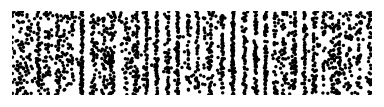

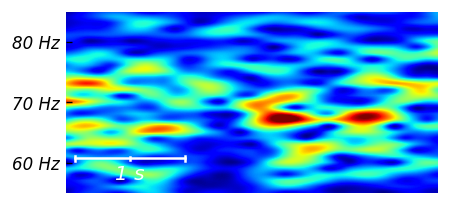

In [1333]:
fname = "sample_2pop_sync.pkl"
data = load_figdat(fname)
if data is None:
    summary_obj = hhtools.SummaryLoader("../three_pop_mpi/simulation_data/data", load_only_control=True)
    obj = summary_obj.load_detail(0,0,2,0,0)
    vlfp = obj["vlfp"][1]
    step_spk = obj["step_spk"]
    save_figdat(fname, {"vlfp": vlfp, "step_spk": step_spk})
else:
    vlfp = data["vlfp"]
    step_spk = data["step_spk"]

psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, obj["ts"], 2000, mbin_t=0.1, wbin_t=1, frange=(3, 100))

""" Generate raster plot """
plt.figure(figsize=(3.3, 1), dpi=120)
hhtools.draw_spk(step_spk, dt=0.01, sequence=np.arange(500, 1000), colors="k", xl=(3.5e3, 4e3), ms=1)
rm_spines()
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

""" Generate spectrogram """
plt.figure(figsize=(4, 2), dpi=120)
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet", interpolation="spline16", vmin=0, vmax=0.8)

# set ticks
plt.xlim([1, 4.4])
plt.ylim([55, 85])
plt.xticks([])
plt.yticks([60, 70, 80], ["60 Hz", "70 Hz", "80 Hz"], style="italic")
rm_spines()
plt.gca().tick_params(axis="y", direction="in")

# add scale bars
ax = plt.gca()
ob = AnchoredHScaleBar(ax=ax, size=1, label="1 s", loc="lower left", frameon=False,
                       pad=0.08, sep=2, linecolor="w", fontcolor="w",
                       fontsize=12, fontstyle="italic")
ax.add_artist(ob)

plt.show()

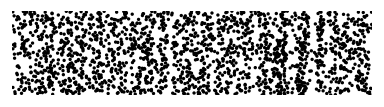

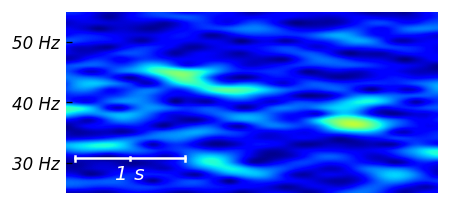

In [1334]:
fname = "sample_2pop_async.pkl"
data = load_figdat(fname)
if data is None:
    summary_obj = hhtools.SummaryLoader("../three_pop_mpi/simulation_data/data", load_only_control=True)
    obj = summary_obj.load_detail(0,0,0,0,0)
    vlfp = obj["vlfp"][1]
    step_spk = obj["step_spk"]
    save_figdat(fname, {"vlfp": vlfp, "step_spk": step_spk})
else:
    vlfp = data["vlfp"]
    step_spk = data["step_spk"]

psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, obj["ts"], 2000, mbin_t=0.1, wbin_t=1, frange=(3, 100))

""" Generate raster plot """
plt.figure(figsize=(3.3, 1), dpi=120)
hhtools.draw_spk(step_spk, dt=0.01, sequence=np.arange(500, 1000), colors="k", xl=(3.2e3, 3.7e3), ms=1)
rm_spines()
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

""" Generate spectrogram """
plt.figure(figsize=(4, 2), dpi=120)
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet", interpolation="spline16", vmin=0, vmax=0.6)

# set ticks
plt.xlim([1, 4.4])
plt.ylim([25, 55])
plt.xticks([])
plt.yticks([30, 40, 50], ["30 Hz", "40 Hz", "50 Hz"], style="italic")
rm_spines()
plt.gca().tick_params(axis="y", direction="in")

# add scale bars
ax = plt.gca()
ob = AnchoredHScaleBar(ax=ax, size=1, label="1 s", loc="lower left", frameon=False,
                       pad=0.08, sep=2, linecolor="w", fontcolor="w",
                       fontsize=12, fontstyle="italic")
ax.add_artist(ob)

plt.show()

# Three population  

## overview 

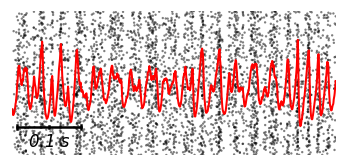

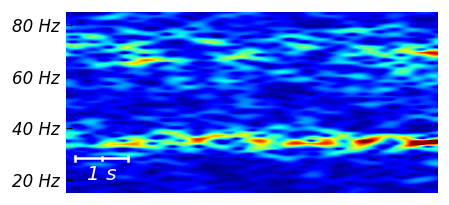

In [1335]:
fname = "sample_3pop.pkl"
data = load_figdat(fname)
if data is None:
    summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples//data", load_only_control=True)
    obj = summary_obj.load_detail(13, 0)
    vlfp = obj["vlfp"][0]
    step_spk = obj["step_spk"]
    save_figdat(fname, {"vlfp": vlfp, "step_spk": step_spk})
else:
    vlfp = data["vlfp"]
    step_spk = data["step_spk"]

psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, obj["ts"], 2000, mbin_t=0.1, wbin_t=1, frange=(3, 100))

def norm(ts, signal, trange, yrange):
    y, ts_n = splice_t(signal, ts, trange)
    y_n = (y - np.min(y)) / (np.max(y) - np.min(y)) * (yrange[1] - yrange[0]) + yrange[0]
    return ts_n, y_n

""" Generate raster plot """
plt.figure(figsize=(3, 1.5), dpi=120)
hhtools.draw_spk(step_spk, dt=0.01, sequence=np.random.randint(low=0, high=2000, size=1000), colors="k", xl=(3.5e3, 4e3), ms=2, alpha=0.5, edgecolor="none")
t, y = norm(obj["ts"]*1e3, vlfp, (3.5e3, 4e3), (200, 800))
plt.plot(t, y, c='r', lw=1.2)
rm_spines()
plt.xticks([]); plt.yticks([])
add_scalebar(100, "0.1 s", loc="lower left", fontcolor="k", fontstyle='italic', borderpad=0.2)
plt.tight_layout()

plt.show()

""" Generate spectrogram """
plt.figure(figsize=(4, 2), dpi=120)
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet", interpolation="spline16", vmin=0, vmax=0.6)

# set ticks
plt.xlim([1, 8])
plt.ylim([15, 85])
yt = np.arange(20, 81, 20)
plt.yticks(yt, ["%d Hz"%(y) for y in yt], style="italic")

plt.xticks([])
# plt.yticks([60, 70, 80], ["60 Hz", "70 Hz", "80 Hz"], style="italic")
rm_spines()
plt.gca().tick_params(axis="y", direction="in")

# add scale bars
ax = plt.gca()
ob = AnchoredHScaleBar(ax=ax, size=1, label="1 s", loc="lower left", frameon=False,
                       pad=0.08, sep=2, linecolor="w", fontcolor="w",
                       fontsize=12, fontstyle="italic")
ax.add_artist(ob)

plt.show()

## Burst extraction sample 

In [500]:
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples/data", load_only_control=True)
with open("../gen_three_pop_samples/multifreq_burst/th_data2.pkl", "rb") as fp:
    th_psd = pkl.load(fp)

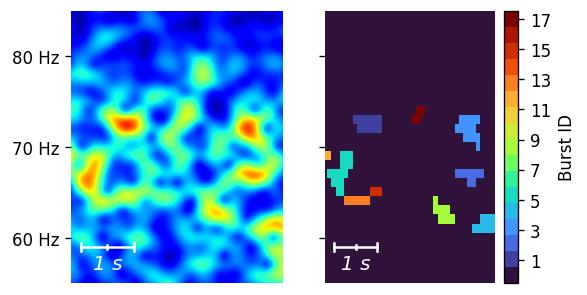

In [1383]:
fname = "burst_extraction_sample.pkl"
data = load_figdat(fname)
if data is None:
    
    with open("../gen_three_pop_samples/multifreq_burst/data/th_psd.pkl", "rb") as fp:
        th_psd = pkl.load(fp)
    
    summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples/data", load_only_control=True)
    cid, nitr, tp = 14, 10, 0

    nid = summary_obj.get_id(cid-1, nitr)
    detail_data = summary_obj.load_detail(nid)
    
    def cut_start(signal, t):
        idt = (t >= 0.5)
        return signal[idt], t[idt]
    
    vlfp, t = cut_start(detail_data["vlfp"][tp+1], detail_data["ts"])
    th_m = th_psd["th_m"][nid, tp]
    th_s = th_psd["th_s"][nid, tp]
    
    save_figdat(fname, {"vlfp": vlfp, "t": t, "th_m": th_m, "th_s": th_s})
else:
    vlfp = data["vlfp"]
    t = data["t"]
    th_m = data["th_m"]
    th_s = data["th_s"]


xl = (5, 9)
flim = (55, 85)


def set_lim():
    plt.xlim(xl); plt.ylim(flim)


psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, t, 2000, mbin_t=0.1, wbin_t=1, frange=(3, 150))
burst_maps = bt.find_blob_filtration(psd, psd_th_m=th_m, psd_th_s=th_s, std_min=3., std_max=8, std_step=0.1, nmin_width=2)

fig, axs = plt.subplots(1, 2, figsize=(5, 3), dpi=120, facecolor='w')
plt.axes(axs[0])
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic", vmin=0, vmax=0.85)
set_lim()
plt.xticks([])
plt.yticks([60, 70, 80], labels=("60 Hz", "70 Hz", "80 Hz"))
rm_spines()

ax = plt.gca()
ob = AnchoredHScaleBar(ax=ax, size=1, label="1 s", loc="lower left", frameon=False,
                       pad=0.08, sep=2, linecolor="w", fontcolor="w",
                       fontsize=12, fontstyle="italic")
ax.add_artist(ob)

plt.axes(axs[1])
cmap = plt.get_cmap("turbo", 17)
hhtools.imshow_xy(burst_maps, x=tpsd, y=fpsd, cmap=cmap, interpolation="none")
set_lim()
plt.yticks([60, 70, 80], labels=("", "", ""))
plt.xticks([])
rm_spines()
utils.draw_categorical_colorbar(17, label="Burst ID")

ax = plt.gca()
ob = AnchoredHScaleBar(ax=ax, size=1, label="1 s", loc="lower left", frameon=False,
                       pad=0.08, sep=2, linecolor="w", fontcolor="w",
                       fontsize=12, fontstyle="italic")
ax.add_artist(ob)

plt.show()

## Clustering result 

### K-score & S-vals

In [596]:
with open("../three_pop_mpi/clustering/data/kmeans_explore.pkl", "rb") as fp:
    kmeans_result = pkl.load(fp)
print(kmeans_result.keys())
num_clusters = [km[0].cluster_centers_.shape[0] for km in kmeans_result["km_obj_sets"]]

dict_keys(['km_obj_sets', 'sval_sets', 'kcoeff_sets', 'scoeff_sets'])


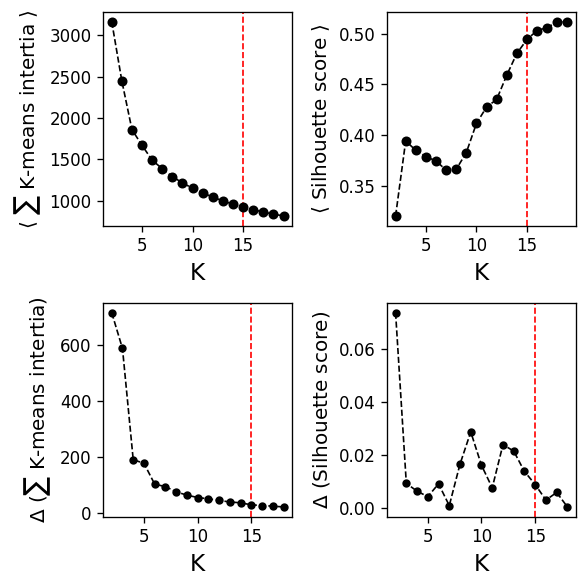

In [1412]:
plt.figure(figsize=(5, 5), dpi=120)

names = ("$\sum$ K-means intertia", "Silhouette score")

for nv, var in enumerate(["kcoeff_sets", "scoeff_sets"]):
    yval = np.average(kmeans_result[var], axis=1)
    
    ax1 = plt.subplot(2,2,nv+1)
    plt.plot(num_clusters, yval, 'k.--', lw=1, ms=10)
    plt.xlabel("K", fontsize=14)
    plt.ylabel(r"$\langle$ %s $\rangle$"%(names[nv]), fontsize=12)
    
    ax2 = plt.subplot(2,2,nv+3)
    dy = yval[1:]-yval[:-1]
    dy2 = np.abs(dy[1:] - dy[:-1])
    
    plt.plot(num_clusters[:-1], np.abs(yval[1:]-yval[:-1]), 'k.--', lw=1, ms=8)
    plt.xlabel("K", fontsize=14)
    plt.ylabel(r"$\Delta$ (%s)"%(names[nv]), fontsize=12)
    
    for ax in [ax1, ax2]:
        yl = ax.get_ylim()
        ax.plot([15, 15], yl, "r--", zorder=-1, lw=1)
        ax.set_ylim(yl)
    
    
plt.tight_layout()
plt.show()

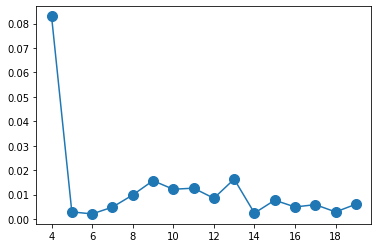

In [1276]:
plt.plot(num_clusters[2:], dy2, '.-', ms=20)

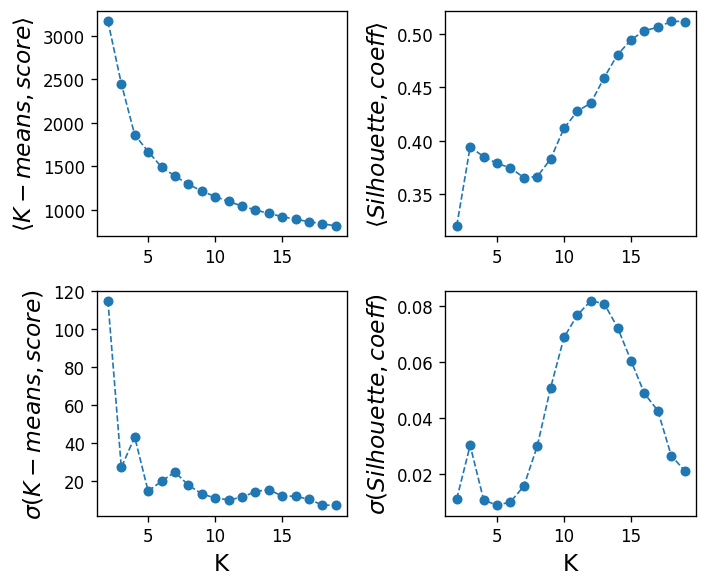

In [598]:
lbs = [[r"$\langle K-means, score \rangle$", r"$\langle Silhouette, coeff \rangle$"],
       [r"$\sigma(K-means, score)$", r"$\sigma(Silhouette,coeff)$"]]

plt.figure(figsize=(6, 5), dpi=120)
n = 1
for i, fn in enumerate([np.average, np.std]):
    for j, vname in enumerate(["kcoeff_sets", "scoeff_sets"]):
        plt.subplot(2, 2, n)
        plt.plot(num_clusters, fn(kmeans_result[vname], axis=1), '.--', lw=1, ms=10)
        n += 1
        
        if i ==1:
            plt.xlabel("K", fontsize=14)
        plt.ylabel(lbs[i][j], fontsize=14)
        
plt.tight_layout()

plt.show()

### stack images 

In [423]:
with open("../three_pop_mpi/clustering/data/rcluster_nrank3_inc_im.pkl", "rb") as fp:
    cluster_data = pkl.load(fp)

In [424]:
# get lines
def get_im_boundary(im):
    nb = im.shape[0]
    lines = []
    
    def is_out(nr, nc):
        return (nc < 0) or (nc >=nb) or (nr < 0) or (nr >= nb)
    
    for i in range(nb):
        for j in range(nb):
            for d in ((-1, 0), (1, 0), (0, -1), (0, 1)):
                r, c = i+d[0], j+d[1]
                if is_out(r, c): continue
                
                if im[i, j] != im[r, c]:
                    if d[1] == 0:
                        lines.append([[j-0.5, j+0.5], [i+0.5*d[0], i+0.5*d[0]]])
                    else:
                        lines.append([[j+0.5*d[1], j+0.5*d[1]], [i-0.5, i+0.5]])
    return lines


lines_cluster = []
for idp in range(7):
    for idr in range(3):
        lines_cluster.append(get_im_boundary(cluster_data["im_stacks"][idr][idp]))

In [440]:
from importlib import reload
reload(hc)

<module 'hhclustering' from '/home/jungyoung/Project/hh_neuralnet/figures/../three_pop_mpi/clustering/hhclustering.py'>

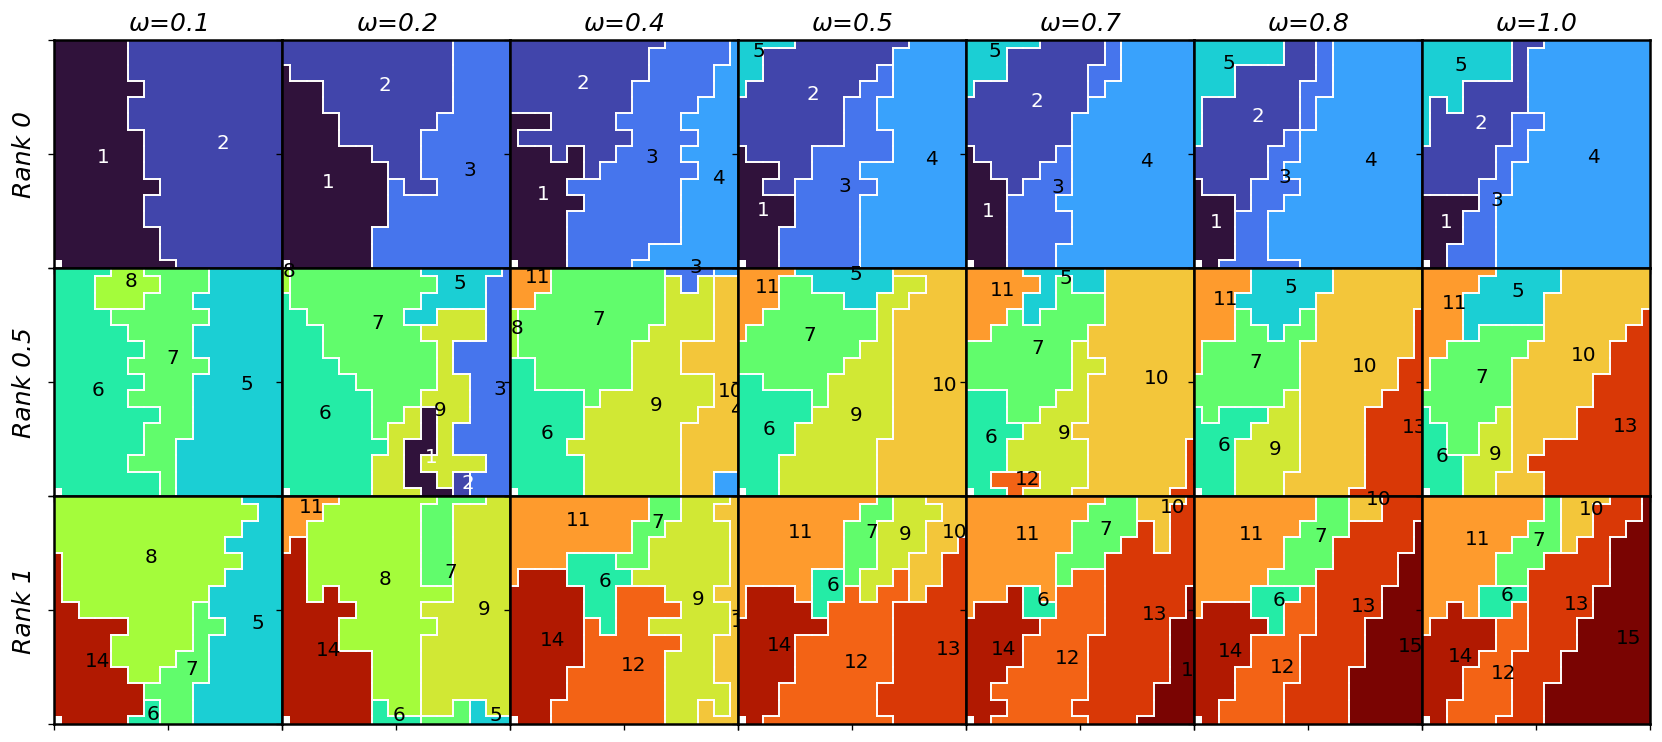

In [484]:
len_p = 0.95/7
len_r = 0.95/3

xy = np.arange(15)

lb_rank = ("Rank 0", "Rank 0.5", "Rank 1")
lb_w = [r"$\omega$=%.1f"%(x) for x in np.linspace(0.1, 1, 7)]

plt.figure(dpi=120, figsize=(14, 6))
for idp in range(7):
    for idr in range(3):
        ax = plt.axes(position=[0.025+len_p*idp, 0.025+(2-idr)*len_r, len_p, len_r])
        
        im = cluster_data["im_stacks"][idr][idp].astype(float)
        im[0, 0] = np.nan
        
        hc.show_sq_cluster(im, x=xy, y=xy, cmap="turbo", cth=2, vmin=1, vmax=15, fontsize=12, aspect="auto")
        for l in lines_cluster[idp*3+idr]:
            plt.plot(l[0], l[1], 'w', lw=1)
        
        plt.xticks([0, 7, 14], labels=["", "", ""])
        plt.yticks([0, 7, 14], labels=["", "", ""])
        plt.xlim([-0, 14]); plt.ylim([0, 14])
        
        if idp == 0:
            plt.ylabel(lb_rank[idr], fontsize=15, style="italic")
        
        if idr == 0:
            plt.title(lb_w[idp], fontsize=15, style="italic")
        
        for n, k in enumerate(("left", "right", "bottom", "top")):
            ax.spines[k].set_color("k")
            ax.spines[k].set_linewidth(1.5)
        
        # ax.spines['bottom'].set_color('blue')
        # ax.spines['left'].set_color('red') 
        # ax.spines["bottom"].set_linewidth(2.5)
        # ax.spines["left"].set_linewidth(2.5)
        # ax.plot(1, 0, ">b", transform=ax.get_yaxis_transform(), clip_on=True)
        # ax.plot(0, 1, "^r", transform=ax.get_xaxis_transform(), clip_on=True)
    # break

plt.show()

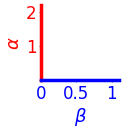

In [490]:
plt.figure(figsize=(2,2), dpi=50)
plt.plot([0, 1], [0, 2], 'w')
plt.xlim([0, 1.1]); plt.ylim([0, 2.2])
rm_spines(("top", "right"))

ax = plt.gca()
for k in ("left", "bottom"):
    ax.spines[k].set_linewidth(5)
    
ax.spines["left"].set_color("r")
ax.spines["bottom"].set_color("b")
    
plt.xticks([0, 0.5, 1], fontsize=24, labels=[0, 0.5, 1], color="b")
plt.yticks([0, 1, 2], fontsize=24, labels=["", 1, 2], color="r")
plt.xlabel(r"$\beta$", fontsize=26, color="b")
plt.ylabel(r"$\alpha$", fontsize=26, color="r")

plt.show()

### Clustering concat data 

In [361]:
with open("../three_pop_mpi/simulation_data/purified_data.pkl", "rb") as fp:
    pdata = pkl.load(fp)
    
with open("../three_pop_mpi/clustering/data/rcluster_nrank3.pkl", "rb") as fp:
    cluster = pkl.load(fp)

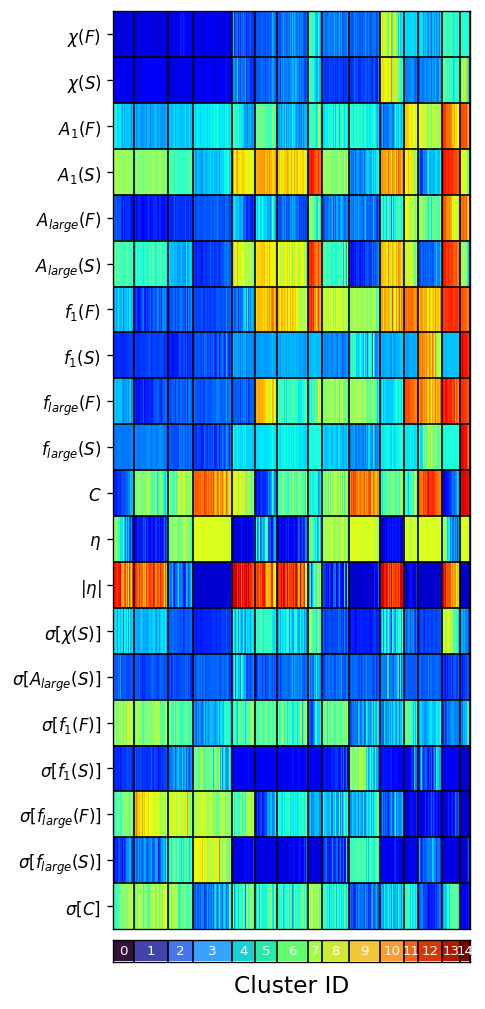

In [1384]:
num_c = 15

fname = "aligned_features.pkl"
data = load_figdat(fname)
if data is None:
    cluster_id = cluster["rcluster_id"]
    sval = cluster["rsval"]
    scoeff = cluster["rscoeff"]
    row_labels = pdata["row_labels"]

    reordered_data, _, bds = hc.reorder_data(pdata["data"], cluster_id, sval)
    sdata = hc.hsmooth(reordered_data)
    
    save_figdat(fname, {"cluster_id": cluster_id, "sval": sval, "scoeff": scoeff, "row_labels": row_labels,
                        "reordered_data": reordered_data, "bds": bds, "sdata": sdata})
else:
    cluster_id = data["cluster_id"]
    sval = data["sval"]
    scoeff = data["scoeff"]
    row_labels = data["row_labels"]
    reordered_data = data["reordered_data"]
    bds = data["bds"]
    sdata = data["sdata"]
    

def draw_vlines():
    for n in range(num_c):
        plt.plot([bds[n], bds[n]], yl, 'k', lw=1)

row_labels_f = []
for l in row_labels:
    if "1/\\tau" in l:
        l = l.replace("1/\\tau", "f")
    elif "\\tau" in l:
        l = l.replace("\\tau", "f")
    row_labels_f.append(l)
    

plt.figure(figsize=(3.5, 9), dpi=120)
plt.axes(position=[0.1, 0.08, 0.85, 0.85])

plt.imshow(sdata, aspect='auto', cmap="jet", interpolation="none")
# plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_labels_f)), labels=row_labels_f)

# grid
xl = plt.xlim(); yl = plt.ylim()
for n in range(len(row_labels_f)):
    plt.plot(xl, [n-0.5, n-0.5], 'k', lw=1)
    
draw_vlines()
plt.xlim(xl)
plt.xticks([])

plt.axes(position=[0.1, 0.05, 0.85, 0.02])
im = np.zeros([2, sdata.shape[1]])
bds0 = [0] + bds
for n in range(num_c):
    im[:, bds0[n]:bds0[n+1]] = n+1
plt.imshow(im, aspect="auto", cmap="turbo")
draw_vlines()

for n in range(num_c):
    plt.text((bds0[n]+bds0[n+1])/2, 0, "%d"%(n), c='w',
            ha="center", va="center", fontsize=8)

plt.ylim([-0.5, 0.5])
plt.yticks([])
plt.xticks([])
plt.xlim(xl)
plt.xlabel("Cluster ID", fontsize=14)
plt.show()

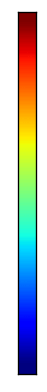

In [1385]:
plt.figure(dpi=120)
plt.imshow(np.linspace(0, 1, 20).reshape(-1, 1), origin="lower", interpolation="spline16", cmap="jet")
plt.yticks([])
plt.xticks([])
# rm_spines()
plt.show()

### tSNE mapping 

In [838]:
# with open("../three_pop_mpi/clustering/tsne_out.pkl", "rb") as fp:
#     tsne_out = pkl.load(fp)
# print(tsne_out.keys())

# tfit = np.array(tsne_out["tsne_data"])[1]

# with open("./tsne_location.pkl", "wb") as fp:
#     pkl.dump({"tsne_fit": tfit}, fp)

with open("./tsne_location.pkl", "rb") as fp:
    tfit = pkl.load(fp)["tsne_fit"]
    # pkl.dump({"tsne_fit": tfit}, fp)

dict_keys(['tsne_data', 'params', 'seeds', 'perplexities'])


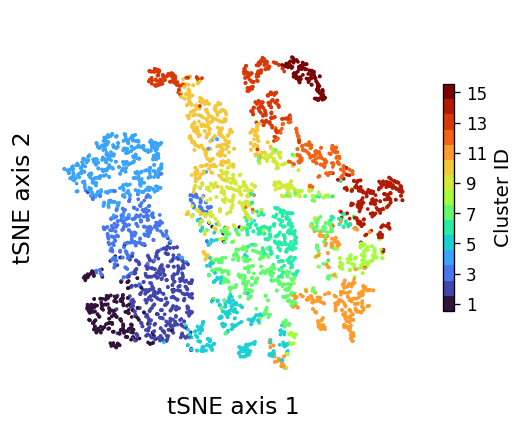

In [859]:
plt.figure(dpi=120, figsize=(5, 5))
plt.scatter(tfit[:, 0], tfit[:, 1], s=5, edgecolor="none", c=cluster_data['rcluster_id'],
           cmap=plt.get_cmap("turbo", 15))
utils.draw_categorical_colorbar(15, shrink=0.5, label="Cluster ID", label_fontsize=12)
rm_spines(); plt.xticks([]); plt.yticks([])
plt.axis("square")
plt.xlabel("tSNE axis 1", fontsize=14)
plt.ylabel("tSNE axis 2", fontsize=14)
plt.show()

## Features samples 

# Burst properties 

In [746]:
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples/data")

## Sample spectrograms 

In [1386]:
def get_psd(cid, nitr, mbin_t=0.05, wbin_t=1):
    
    fname = "sample_psd_%02d.pkl"%(cid)
    data = load_figdat(fname)
    if data is None:
        detail_data = summary_obj.load_detail(cid-1, nitr)
        vlfp, ts = detail_data["vlfp"], detail_data["ts"]
        save_figdat(fname, {"vlfp": vlfp, "ts": ts})
    else:
        vlfp = data["vlfp"]
        ts = data["ts"]
        
    fs = 2000
    psd_set = []
    for v in vlfp:
        psd, fpsd, tpsd = hhsignal.get_stfft(v, ts, fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=(3, 100))
        psd_set.append(psd)
    return psd_set, fpsd, tpsd


def show_psd(cid, nitr, xl, yl, yticks, vmax):
    psd_set, fpsd, tpsd = get_psd(cid, nitr)
    
    plt.figure(dpi=120, figsize=(2.5, 6))
    ntp = (0,1,2)
    lb = ("Total", "Fast", "Slow")
    
    for i in range(3):
        plt.axes(position=(0.1, 1-0.3*i, 0.8, 0.28))

        hhtools.imshow_xy(psd_set[ntp[i]], x=tpsd, y=fpsd, vmax=vmax, vmin=0, cmap="jet", interpolation="spline16")
        plt.xlim(xl)
        plt.ylim(yl)
        plt.text(xl[0]+0.5, yl[1]-10, lb[ntp[i]], c="w", ha="center", fontsize=14, fontstyle="italic", fontweight="bold")

        plt.xticks([])
        add_scalebar(1, "1s", loc="lower right", fontcolor="w", linecolor="w")
        rm_spines()

        plt.yticks(yticks, labels=["%d Hz"%(y) for y in yticks])

    plt.show()

### Cluster 4 

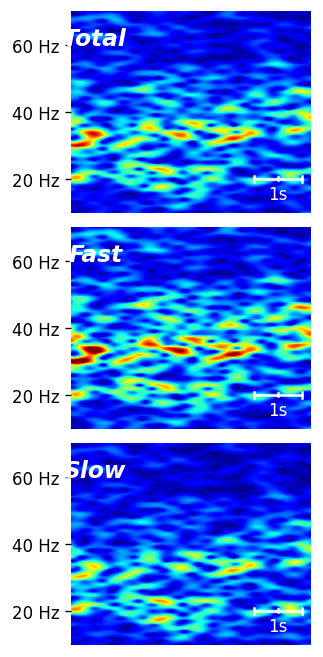

In [1389]:
show_psd(4, 0, (3, 8), [10, 70], [20, 40, 60], 0.25)

### Cluster 15 

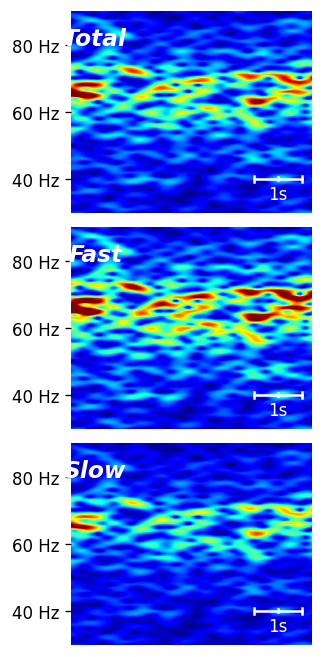

In [1390]:
show_psd(15, 0, (3, 8), [30, 90], [40, 60, 80], 0.6)

### Cluster 9 

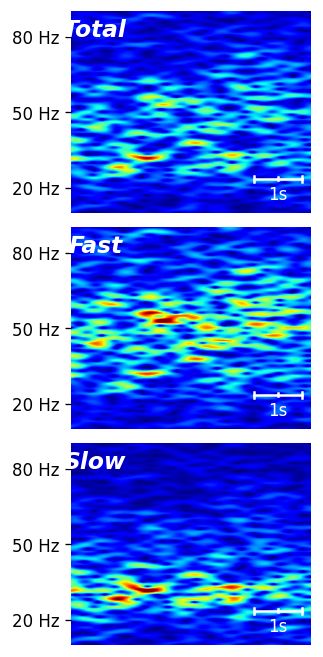

In [1391]:
show_psd(9, 0, (3, 8), [10, 90], [20, 50, 80], 0.4)

### Cluster 11

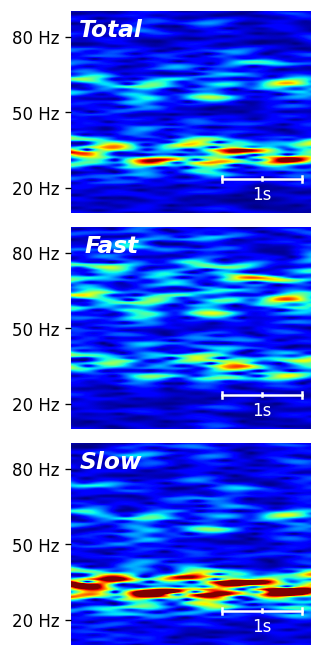

In [1392]:
show_psd(11, 2, [5, 8], [10, 90], [20, 50, 80], 1.5)

## Burst joint prob

In [1022]:
from scipy.ndimage import gaussian_filter


def align_burst(burst_info):
    data = []
    col_names = ["burst_f", "burst_range", "burst_amp"]
    for n in range(len(burst_info["burst_f"])):
        for i in range(len(burst_info["burst_f"][n])):
            data_sub = [
                burst_info["burst_f"][n][i],
                burst_info["burst_amp"][n][i],
                burst_info["burst_range"][n][i][1] - burst_info["burst_range"][n][i][0],
                burst_info["cluster_id"][n],
                burst_info["pop_type"][n]
            ]
            data.append(data_sub)
    df_burst = pd.DataFrame(data, columns=["burst_f", "burst_amp", "burst_duration", "cluster_id", "pop_type"])
    if df_burst["cluster_id"].min() == 0:
        df_burst["cluster_id"] += 1
    
    return df_burst

def compute_joint(df_burst, cid=1, pop_type=0, itv=(2, 0.02),
                  row_range=(10, 100), col_range=(0.1, 2), sigma=(0, 0)):
    
    # row: f, col: amp
    if cid < 1: raise ValueError("Wrong cluster id")
    df_sub = df_burst[(df_burst["cluster_id"] == cid) & (df_burst["pop_type"] == pop_type)]
    
    if any(df_sub["burst_f"] >= row_range[1]):
        print("burst_f exceeds expected range, max: %.2f"%(np.max(df_sub["burst_f"])))
    
    if any(df_sub["burst_amp"] >= col_range[1]):
        print("burst_amp exceeds expected range, max: %.2f"%(np.max(df_sub["burst_amp"])))
        
    def in_range(df, df_range):
        return (df >= df_range[0]) & (df < df_range[1])
        
    df_in = df_sub[in_range(df_sub["burst_f"], row_range) & in_range(df_sub["burst_amp"], col_range)]
    
    numf = int((row_range[1] - row_range[0])/itv[0])
    numa = int((col_range[1] - col_range[0])/itv[1])
        
    joint_map = np.zeros([numf, numa])
    rset = np.floor((df_in["burst_f"] - row_range[0]) / itv[0]).astype(int)
    cset = np.floor((df_in["burst_amp"] - col_range[0]) / itv[1]).astype(int)
        
    for r, c in zip(rset, cset):
        if r >= numf: continue
        if c >= numa: continue
        
        joint_map[r, c] += 1
        
    if len(rset) > 0: joint_map /= len(rset)
    
    sigma = (int(sigma[0]/itv[0]), int(sigma[1]/itv[1]))
    joint_map = gaussian_filter(joint_map, sigma)
    
    return joint_map, len(df_in)


def adjust_range(vals, boundary, dr):
    vmin = np.min(vals)
    vmax = np.max(vals)
    
    # print(np.floor((vmin - boundary[0])/dr)*dr)# + boundary[0])
    rmin = np.max([boundary[0], np.floor((vmin - boundary[0])/dr)*dr + boundary[0]])
    rmax = np.min([boundary[1], boundary[1] - np.floor((boundary[1] - vmax)/dr).round()*dr])
    return (rmin, rmax)


def draw_joint_map(joint_map, row_range, col_range, cmap="jet", interpolation="none", vm=0.1):
    dr = (row_range[1] - row_range[0])/joint_map.shape[0]
    dc = (col_range[1] - col_range[0])/joint_map.shape[1]
    plt.imshow(joint_map, interpolation=interpolation, cmap=cmap,
               extent=(col_range[0]-dc, col_range[1]+dc, row_range[0]-dr, row_range[1]+dr),
               aspect="auto", origin="lower", vmin=0, vmax=vm)
    

In [794]:
bmap_name = "../gen_three_pop_samples/multifreq_burst/data/burst_map.pkl"
th_types = "abs"


with open(bmap_name, "rb") as fp:
    burst_info = pkl.load(fp)
df_burst = align_burst(burst_info)

In [1310]:
def draw_burst_joint(cid, frange=(10, 90), arange=(0.1, 2.1), fticks=None, vmax=(0.05, 0.05)):
    df = 2
    da = 0.01
    sigma = (df, da)
    lb_tp = ("F", "S")
    
    fname = "bprob_%02d.pkl"%(cid)
    data = load_figdat(fname)
    data2save = {"joint": [], "num_b": []}
    
    plt.figure(dpi=120, figsize=(6, 1.5))
    for tp in range(2):
        if data is None:
            joint, num_b = compute_joint(df_burst, cid=cid, pop_type=tp, itv=(df, da), row_range=frange, col_range=arange, sigma=sigma)
            data2save["joint"].append(joint); data2save["num_b"].append(num_b)
        else:
            joint, num_b = data["joint"][tp], data["num_b"][tp]

        # plt.subplot(1,2,tp+1)
        # plt.subplot(1,2,tp+1)
        plt.axes(position=(0.05+0.4*tp, 0.1, 0.3, 0.8))
        draw_joint_map(joint, frange, arange, cmap="turbo", interpolation="bicubic", vm=vmax[tp])
        # set_labels(frange=adj_frange, arange=adj_arange)
        plt.title("pop %s"%(lb_tp[tp]), fontsize=14)
        plt.xlabel("Burst amplitude", fontsize=13)
        plt.yticks(fticks, labels=["%d Hz"%(f) for f in fticks], fontstyle="italic")
        plt.grid(True, lw=0.5, alpha=0.5, linestyle="--", color="w")
        
        cbar = plt.colorbar()
        # cbar.set_ticks(ticks=(0, vmax[tp]), fontsize=10, fontstyle="italic")
        cbar.set_ticks(ticks=(0, vmax[tp]), labels=["0", "%.3f"%(vmax[tp])])
        ticklabs = cbar.ax.get_yticklabels()
        cbar.ax.set_yticklabels(ticklabs, fontsize=8, fontstyle="normal")
        rm_spines()
        
    plt.show()
    
    if data is None: save_figdat(fname, data2save)
    

### Cluster 4 

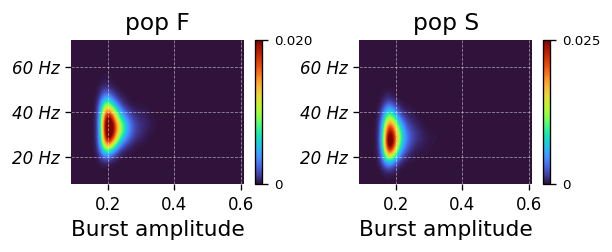

In [1311]:
draw_burst_joint(4, frange=(10, 70), arange=(0.1, 0.6), fticks=(20, 40, 60), vmax=(0.02, 0.025))

### Cluster 15 

burst_amp exceeds expected range, max: 1.09


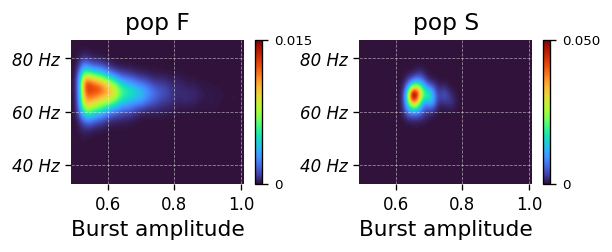

In [1312]:
draw_burst_joint(15, frange=(35, 85), arange=(0.5, 1), fticks=(40, 60, 80), vmax=(0.015, 0.05))

### Cluster 9 

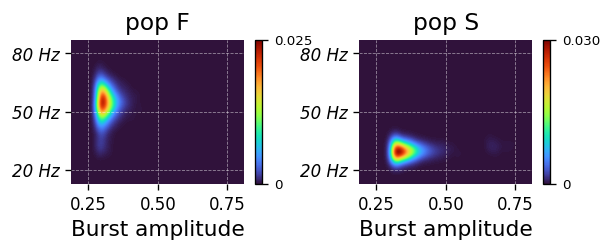

In [1313]:
draw_burst_joint(9, frange=(15, 85), arange=(0.2, 0.8), fticks=(20, 50, 80), vmax=(0.025, 0.03))

### Cluster 11 

burst_f exceeds expected range, max: 99.10
burst_f exceeds expected range, max: 87.09
burst_amp exceeds expected range, max: 2.14


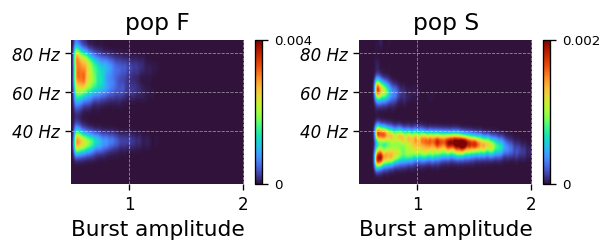

In [1314]:
draw_burst_joint(11, frange=(15, 85), arange=(0.5, 2), fticks=(40, 60, 80), vmax=(0.004, 0.002))

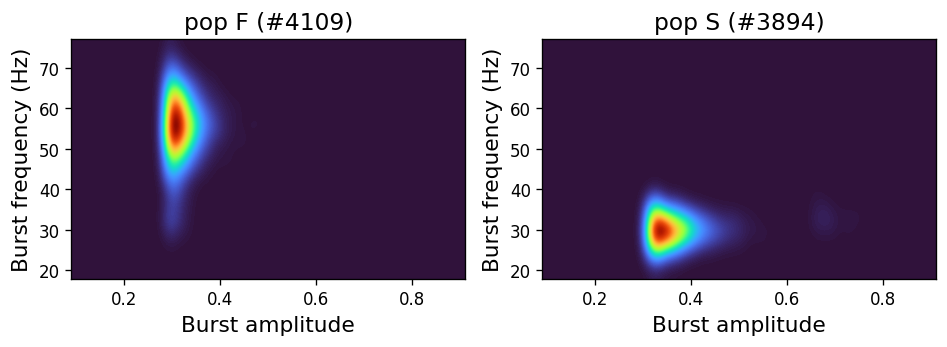

In [1015]:
cid = 9

frange = (10, 90)
arange = (0.1, 2.1)
df = 2
da = 0.01
sigma = (df, da)

df_sub = df_burst[df_burst["cluster_id"] == cid]
adj_frange = adjust_range(df_sub["burst_f"], frange, 5)
adj_arange = adjust_range(df_sub["burst_amp"], arange, 0.2)

lb_tp = ("F", "S")
plt.figure(dpi=120, figsize=(8, 3))
for tp in range(2):
    joint, num_b = compute_joint(df_burst, cid=cid, pop_type=tp, itv=(df, da), row_range=adj_frange, col_range=adj_arange, sigma=sigma)

    # plt.subplot(1,2,tp+1)
    plt.subplot(1,2,tp+1)
    draw_joint_map(joint, adj_frange, adj_arange, cmap="turbo", interpolation="bicubic")
    # set_labels(frange=adj_frange, arange=adj_arange)
    plt.title("pop %s (#%d)"%(lb_tp[tp], num_b), fontsize=14)
    plt.xlabel("Burst amplitude", fontsize=13)
    plt.ylabel("Burst frequency (Hz)", fontsize=13)
plt.tight_layout()
plt.show()

## Burst correaltion 

In [824]:
with open("../gen_three_pop_samples/multifreq_burst/data/corr_map1.pkl", "rb") as fp:
    corr_data = pkl.load(fp)
print(corr_data.keys())
print(corr_data["params"])

# th_types = "abs"/

dict_keys(['pcorr_maps', 'bcorr_maps', 'num_detected', 'amp_ranges', 'desc', 'fpsd', 'params'])
{'mbin_t': 0.01, 'wbin_t': 1, 'flim': (10, 100), 'std_min': 3.2, 'std_max': 8.0, 'std_step': 0.1, 'nmin_width': 5, 'amp_ranges': (0.1, 2.1), 'fdir': '../data'}


In [1315]:
def show_corr_map(corr_map, x, axs=None, dpi=120, figsize=(8, 3), vm=0.2, xl=None, cmap="RdBu_r"):
    if xl is None: xl = [x[0], x[-1]]
    
    def add_ac_axis():
        def _set_spines(labels, cs, lw=1.5):
            for k in labels:
                ax.spines[k].set_color(cs)
                ax.spines[k].set_linewidth(lw)
        
        ax = plt.gca()
        # fast pop
        ax.tick_params('x', top=True, labeltop=True, color="k")
        _set_spines(("top", "left"), "r", lw=1.5)
        ax.spines["top"].set_label("Fast")
        ax.spines["left"].set_label("Fast")

        # # slow pop
        ax.tick_params('y', right=True, labelright=True, color="b")
        _set_spines(("bottom", "right"), "b", lw=1.)
        # plt.plot(x[1:], x[:-1], 'b', lw=1.5)
        # plt.plot(x, x+1, 'k', lw=2)
        ax.spines["top"].set_label("Fast")
        ax.spines["left"].set_label("Fast")
    
    # plt.subplot(211)
    if axs is None:
        plt.axes(position=(0.1, 0.55, 0.8, 0.4))
    else:
        plt.axes(axs[0])
        
    im = np.triu(corr_map[:,:,3]) + np.tril(corr_map[:,:,0])
    for i in range(im.shape[0]):
        im[i, i] = 0
    hhtools.imshow_xy(im, x=x, y=x, cmap=cmap, vmin=-vm, vmax=vm, interpolation="none")
    plt.xlim(xl)
    plt.axis("square")
    plt.xlabel("Slow", fontsize=14, color="b")
    plt.ylabel("Fast", fontsize=14, color="r")
    add_ac_axis()

    if axs is None:
        plt.axes(position=(0.1, 0.1, 0.8, 0.4))
    else:
        plt.axes(axs[1])
    
    hhtools.imshow_xy(corr_map[:,:,1], x=x, y=x, cmap=cmap, vmin=-vm, vmax=vm, interpolation="none")
    plt.xlim(xl)
    plt.axis("square")
    plt.xlabel("Slow", fontsize=14)
    plt.ylabel("Fast", fontsize=14)
    

def draw_corr_map_all(cid, vm_p=0.1, vm_c=5e-4):
    plt.figure(dpi=120, figsize=(5, 5))
    axes = [
        plt.axes(position=(0.1, 0.55, 0.3, 0.4)),
        plt.axes(position=(0.1, 0.1, 0.3, 0.4)),
        plt.axes(position=(0.62, 0.55, 0.3, 0.4)),
        plt.axes(position=(0.62, 0.1, 0.3, 0.4))
    ]
    
    fname = "corr_submap_%02d.pkl"%(cid)
    data = load_figdat(fname)
    if data is None:
        pcorr = corr_data["pcorr_maps"][cid-1]
        bcorr = corr_data["bcorr_maps"][cid-1][0]
        save_figdat(fname, {"pcorr_map": pcorr, "bcorr_map": bcorr})

    else:
        pcorr = data["pcorr_map"]
        bcorr = data["bcorr_map"]
    
    show_corr_map(pcorr, corr_data["fpsd"], vm=vm_p, axs=axes[:2])
    show_corr_map(bcorr, corr_data["fpsd"], vm=vm_c, axs=axes[2:], cmap="bwr")
        

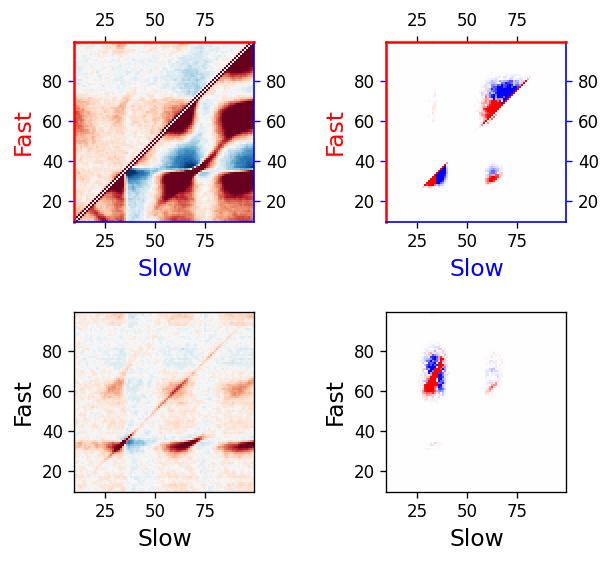

In [1316]:
draw_corr_map_all(14, vm_p=0.2, vm_c=1e-3)

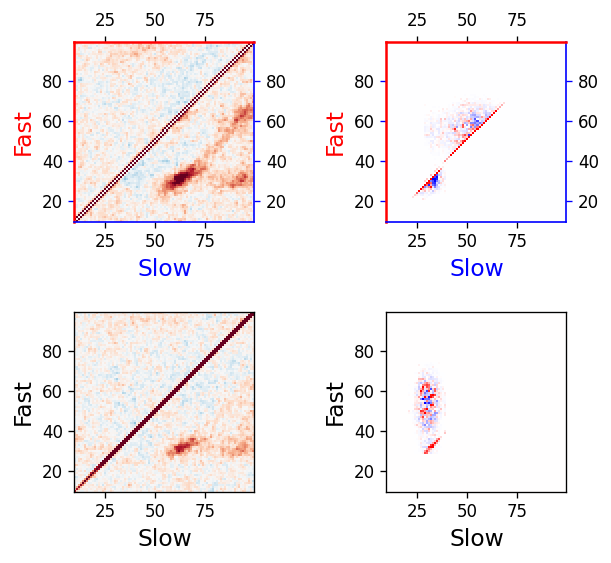

In [1317]:
draw_corr_map_all(9, vm_p=0.1, vm_c=5e-4)

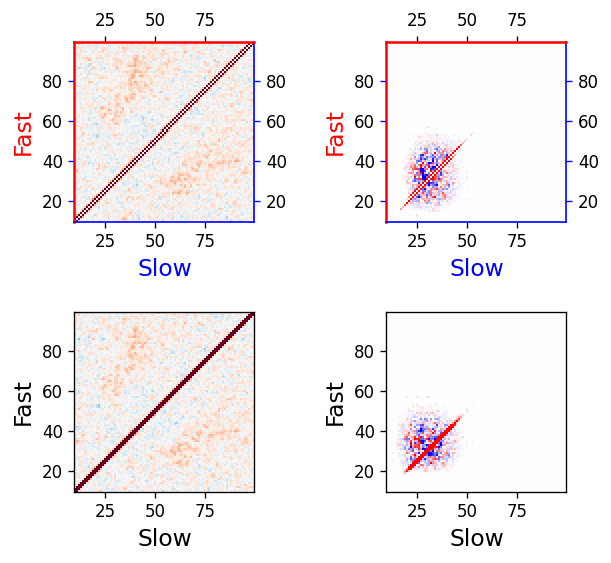

In [1318]:
draw_corr_map_all(4)

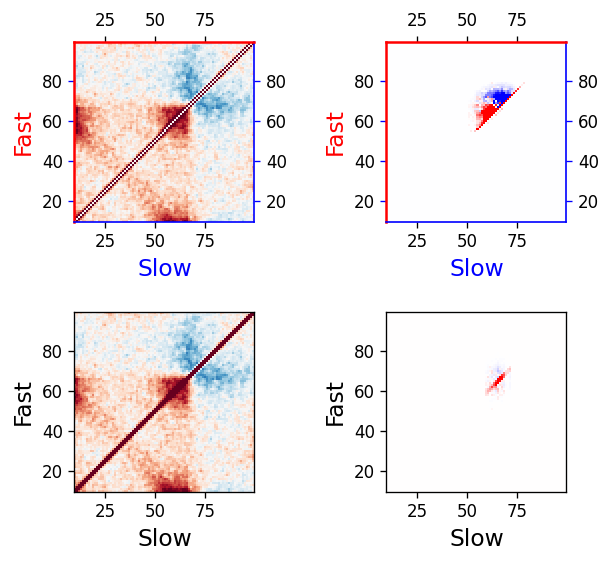

In [1319]:
draw_corr_map_all(15)

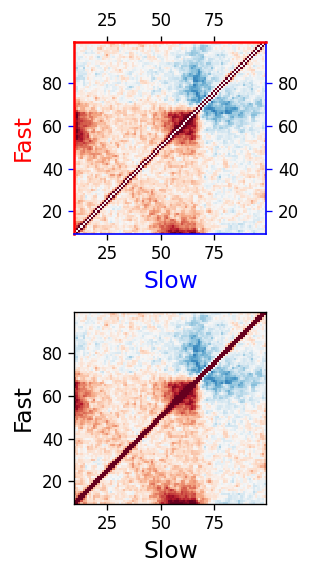

In [1143]:
cid = 15

# plt.figure(dpi=120, figsize=(7.5, 3))
plt.figure(dpi=120, figsize=(2., 5.))
show_corr_map(corr_data["pcorr_maps"][cid-1], corr_data["fpsd"], vm=0.1)
plt.show()

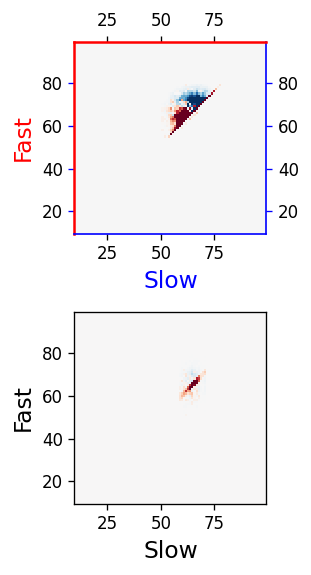

In [1145]:
cid = 15

# plt.figure(dpi=120, figsize=(7.5, 3))
plt.figure(dpi=120, figsize=(2., 5.))
show_corr_map(corr_data["bcorr_maps"][cid-1][0], corr_data["fpsd"], vm=5e-4)
plt.show()

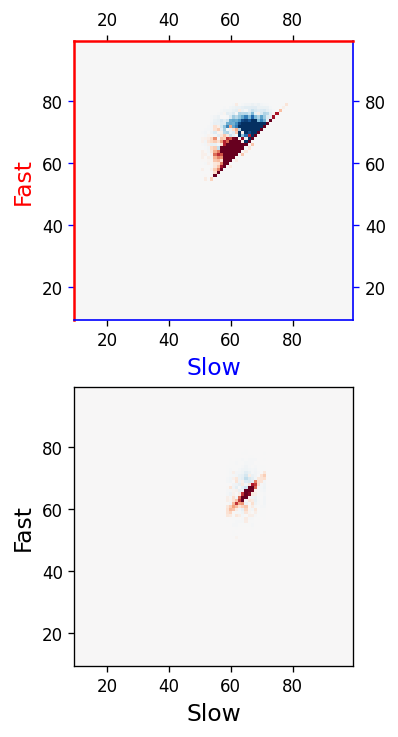

In [1134]:
cid = 15

plt.figure(dpi=120, figsize=(3, 7))
show_corr_map(corr_data["bcorr_maps"][cid-1][0], corr_data["fpsd"], vm=5e-4)
plt.show()

# Other figures 

In [1393]:
fname = "feature_sample.pkl"
data_buf = load_figdat(fname)
if data_buf is None:
    obj_summary = hhtools.SummaryLoader("../three_pop_mpi/simulation_data/data", load_only_control=True)
    data = obj_summary.load_detail(8, 5, 2, 0, 0)
    save_figdat(fname, {"data": data})
else:
    data = data_buf["data"]



## Auto-correlation 

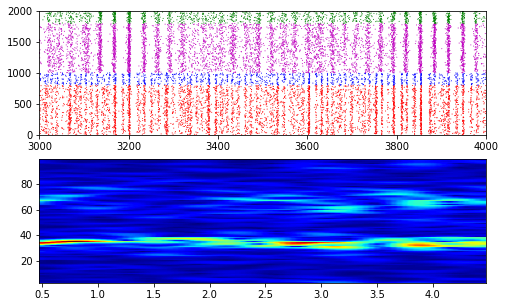

In [1394]:
# obj_summary = hhtools.SummaryLoader("../three_pop_mpi/simulation_data/data", load_only_control=True)
# data = obj_summary.load_detail(8, 5, 2, 0, 0)

N = 2000
psd, fpsd, tpsd = hhsignal.get_stfft(data["vlfp"][0], data["ts"], 2000, mbin_t=0.05, wbin_t=1, frange=(3, 100))

plt.figure(figsize=(8, 5))

plt.subplot(211)
hhtools.draw_spk(data["step_spk"], xl=(3000, 4000),
                 color_ranges=[800, 1000, 1800, 2000],
                 colors=["r", "b", "m", "g"], ms=1, edgecolors='none')

plt.subplot(212)
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet")
plt.show()

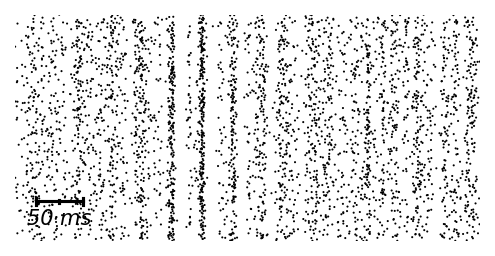

In [1395]:
np.random.seed(300)
xl = (3000, 3500)

plt.figure(dpi=150, figsize=(4, 2))
hhtools.draw_spk(data["step_spk"], xl=xl,
                 sequence=np.random.choice(N, size=1000, replace=False),
                 colors='k', ms=1, edgecolors='none')
add_scalebar(50, "50 ms", fontstyle="italic")
rm_spines()
plt.xticks([])
plt.yticks([])
plt.show()

In [698]:
def norm(ts, signal, trange, yrange):
    y, t = splice_t(signal, ts, trange)
    y_n = (y - np.min(y)) / (np.max(y) - np.min(y)) * (yrange[1] - yrange[0]) + yrange[0]
    return ts_n, y_n

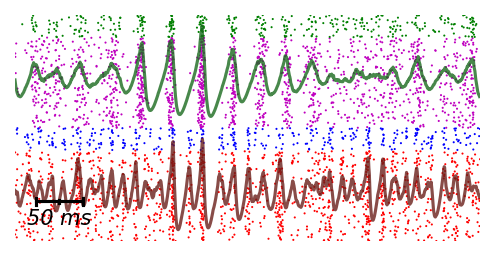

In [686]:
np.random.seed(300)
xl = (3000, 3500)
# cs = ["#bd0808", "#1c12db", "#db7612", "#237516"]
cs = ["r", "b", "m", "g"]

plt.figure(dpi=150, figsize=(4, 2))
hhtools.draw_spk(data["step_spk"], xl=xl,
                 sequence=np.concatenate((np.arange(400), np.arange(800, 900), np.arange(1000, 1400), np.arange(1800, 1900))),
                 color_ranges=[400, 500, 900, 1000],
                 colors=cs, ms=1, edgecolors="none")

ts, yf = norm(data["ts"]*1e3, data["vlfp"][1], xl, [ 50, 450])
_,  ys = norm(data["ts"]*1e3, data["vlfp"][2], xl, [550, 950])

plt.plot(ts, yf, alpha=0.8, lw=1.5, c="#6b1f1a")
plt.plot(ts, ys, alpha=0.8, lw=1.5, c="#1a6b1e")

add_scalebar(50, "50 ms", fontstyle="italic")
rm_spines()
plt.xticks([])
plt.yticks([])
plt.show()

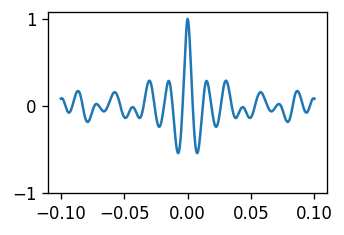

In [727]:
vlfp = data["vlfp"][1]
y, t = splice_t(vlfp, data["ts"], [2, 3])
ac, tlag = hhsignal.get_correlation(y, y, 2000, max_lag=0.1)

plt.figure(dpi=120, figsize=(3, 2))
plt.plot(tlag, ac)
# rm_spines()
plt.yticks([-1, 0, 1])
plt.show()

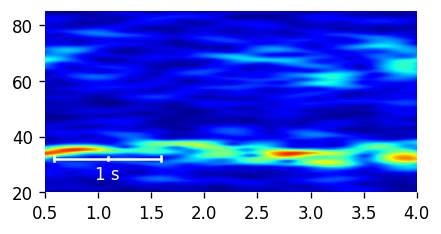

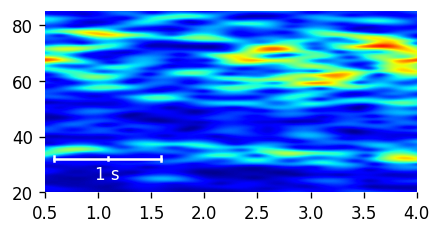

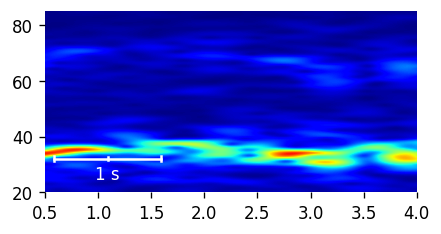

In [745]:
ylims = [[20, 85], [20, 85], [20, 85]]

for tp in range(3):
    psd, fpsd, tpsd = hhsignal.get_stfft(data["vlfp"][tp], data["ts"], 2000, mbin_t=0.05, wbin_t=1, frange=(3, 100))
    
    plt.figure(figsize=(4, 2), dpi=120)
    hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic")
    plt.xlim([0.5, 4])
    rm_spines()
    add_scalebar(1, label="1 s", linecolor="w", fontcolor="w")
    plt.ylim(ylims[tp])
    plt.show()

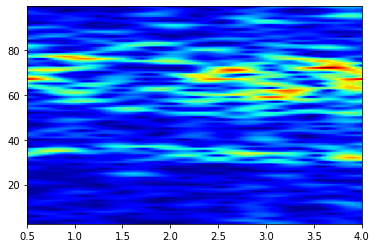

In [737]:
psd, fpsd, tpsd = hhsignal.get_stfft(data["vlfp"][1], data["ts"], 2000, mbin_t=0.05, wbin_t=1, frange=(3, 100))
plt.figure()
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet")
plt.xlim([0.5, 4])
plt.show()

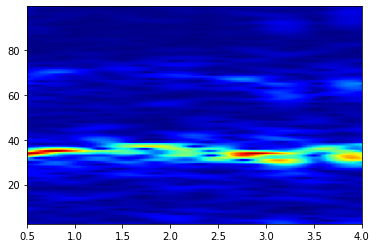

In [738]:
psd, fpsd, tpsd = hhsignal.get_stfft(data["vlfp"][2], data["ts"], 2000, mbin_t=0.05, wbin_t=1, frange=(3, 100))
plt.figure()
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet")
plt.xlim([0.5, 4])
plt.show()